
This script analyzes the time-series oceanographic data published in Bitter et al. X

Note that manuscript refers to the "bay" as coastal site. The lagoon site is the lagoon site in the manuscript


In [ ]:
library(ggplot2); library(seacarb); # this has the seafet functions (sf_...)
library(reshape2); library(plyr); library(dplyr);
library(xts) #interactive plots
library(RVAideMemoire)
library(Rmisc)
library(gridExtra)
library(plyr)
library(grid)
library(PMCMRplus)

In [9]:
#Load data

##remember, bay = coastal site
bay <- read.csv("./SF_VF.csv")
colnames(bay) <- c("Date", "Temp", "pH")
bay_all <- read.csv("data_bitter_kapsenberg.csv")
colnames(bay_all) <- c("Date", "Temp", "pH")
colnames(lagoon) <- c("Date", "Temp", "pH")
bay$pH <- as.numeric(bay$pH)
bay$H_ion <- 10^-(bay$pH)
#formatting date/time accordingly for analyses 
bay$Date <- as.POSIXct(as.POSIXlt(as.character(bay$Date), tz="GMT", format = "%m/%d/%y %H:%M"))

lagoon <- read.csv("./SF_SETE.csv")
lagoon <- lagoon[,c(5, 12, 15)]
colnames(lagoon) <- c("Date", "Temp", "pH")
lagoon$pH <- as.numeric(lagoon$pH)
lagoon$H_ion <- 10^-(lagoon$pH)
#formatting date/time accordingly for analyses 
lagoon$Date <- as.POSIXct(as.POSIXlt(as.character(lagoon$Date), tz="GMT", format = "%m/%d/%y %H:%M"))



In [11]:
#Compute summary stats of pH at each site


##Mean at each site
-log10(mean(bay$H_ion)) #8.07
-log10(mean(lagoon$H_ion)) #8.11

##Range of pH at each site
-log10(range(bay$H_ion)) #7.96-8.16
-log10(range(lagoon$H_ion)) #7.47-8.39

[1] 8.070091

[1] 8.107538

[1] 8.156480 7.956011

[1] 8.391766 7.471563

In [17]:
#Some more advanced statistics to infer differences in pH profiles at each site

##Bind dataframes
bay$Site <- "Coastal"
lagoon$Site <- "Lagoon"
all_pH <- rbind(bay, lagoon)


##KS test 
ks.test(bay$pH, lagoon$pH) #D = 0.45915, p-value < 2.2e-16

##Permanova on pH distributions 
perm.anova(pH ~ Site, data = all_pH, nperm = 999) #F (1, 25035) = 1456.8686, p = 0.001, 



##hartleyTest Fmax test
b <- as.data.frame(bay$pH)
b$Site <- "Bay"
l <- as.data.frame(lagoon$pH)
l$Site <- "Lagoon"
colnames(b) <- c("pH", "Site")
colnames(l) <- c("pH", "Site")
data <- rbind(b, l)
data$Site <- as.factor(data$Site)
hartleyTest(pH ~ Site, data = data)





Warning message in ks.test(bay$pH, lagoon$pH):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  bay$pH and lagoon$pH
D = 0.45915, p-value < 2.2e-16
alternative hypothesis: two-sided


  |======================================================================| 100%


,Sum Sq,Df,Mean Sq,F value,Pr(>F)
,<dbl>,<int>,<dbl>,<chr>,<chr>
Site,13.69114,1,13.691139152,1456.86862883565,0.00100
Residuals,235.27013,25035,0.009397648,,NA


Warning message in hartleyTest.default(c(8.046068773, 8.04475722, 8.043918501, 8.044233724, :
“Maximum F-ratio test is imprecise for unbalanced designs.”


	Hartley's maximum F-ratio test of homogeneity of variances

data:  pH by Site
F Max = 5.2704, df = 8044, k = 2, p-value < 2.2e-16



Plotting time-series of pH at each site


Saving 7 x 7 in image


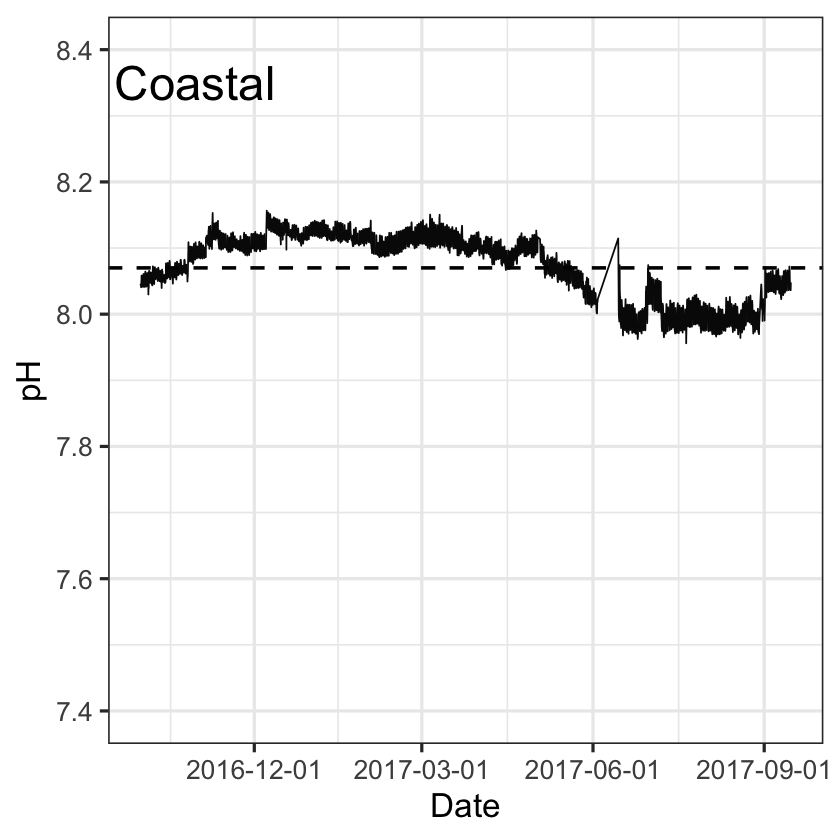

In [12]:
#bay (coastal) plot black and white
bay_p <- ggplot(data = bay, aes(Date, pH)) +
    geom_line(colour = 'grey3') +
    ylim(7.4, 8.4) +
    geom_hline(yintercept = 8.07, colour = "black", linetype="dashed", size = 1) +
    xlab("Date") +
    theme_bw(base_size = 20) +
    scale_x_datetime(date_breaks = "3 month") +
    annotate("text", x = bay[700,1], y = 8.35, label = "Coastal", size = 10)


bay_p + ggsave("./bay_pH_bw.pdf")

Saving 7 x 7 in image


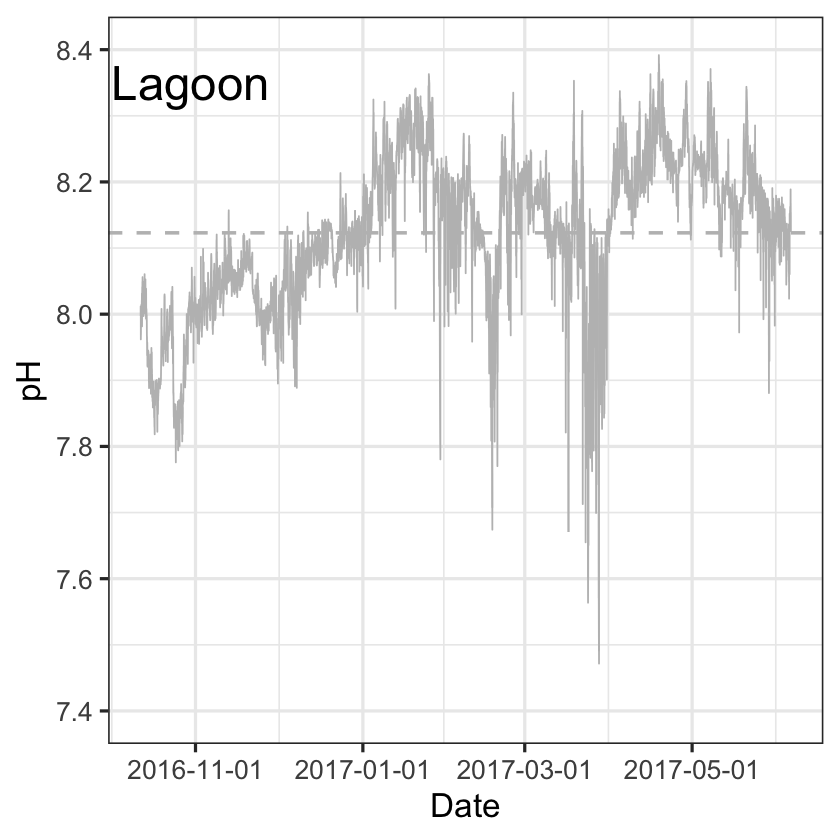

In [13]:
#lagoon plot black and white
lagoon_p <- ggplot(data = lagoon, aes(Date, pH)) +
    geom_line(colour = 'grey') +
    ylim(7.4, 8.4) + 
    geom_hline(yintercept = mean(lagoon$pH), colour = "grey", linetype="dashed", size = 1) +
    xlab("Date") +
    theme_bw(base_size = 20) +
    scale_x_datetime(date_breaks = "2 month") +
    annotate("text", x = bay[700,1], y = 8.35, label = "Lagoon", size = 10)
lagoon_p + ggsave("./lagoon_pH_bw.pdf")

Plotting overlaid densities of observed pH values at each site

Saving 7 x 7 in image


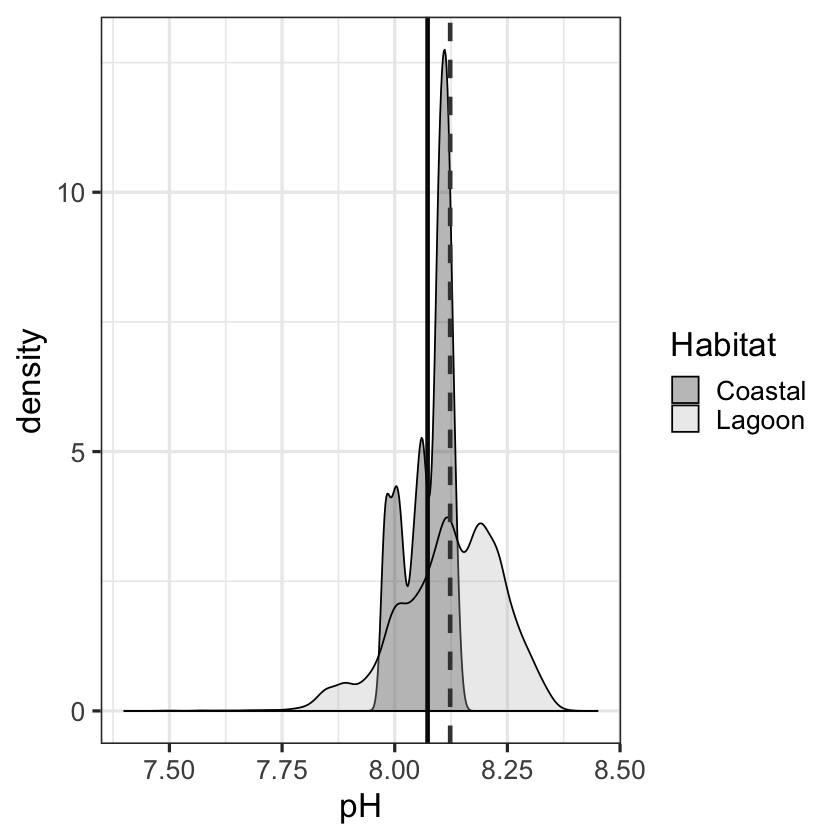

In [18]:
#densities in bw
p <- ggplot(all_pH, aes(x = pH, fill = Site)) +
    geom_density(alpha = 0.3) + 
    scale_fill_manual("Habitat", values = c("Lagoon" = "grey", "Coastal" = "grey3")) +
    geom_vline(xintercept = mean(bay$pH), colour = "grey3", size = 1.3) +
    geom_vline(xintercept = mean(lagoon$pH), colour = "grey25", linetype = "dashed",  size = 1.3) +
    xlim(7.4, 8.45) +
    theme_bw(base_size = 20)

p + ggsave("./pH_densities_bw.pdf")


Identifying differences in temporal autocorrelation at each site


In [19]:
#Computing autocorrelation using daily lags
b.auto <- acf(bay$pH, plot = FALSE)
l.auto <- acf(lagoon$pH, plot = FALSE)

b.auto <- as.data.frame(b.auto$acf[0:40])
b.auto$Lag <- seq(from = 1, to = 40, by = 1)
colnames(b.auto) <- c("Autocorr", "Lag")
l.auto <- as.data.frame(l.auto$acf[0:40])
l.auto$Lag <- seq(from = 1, to = 40, by = 1)
colnames(l.auto) <- c("Autocorr", "Lag")

b.auto$Habitat <- "Coastal"
l.auto$Habitat <- "Lagoon"

all.auto <- rbind(b.auto, l.auto)


Saving 7 x 7 in image


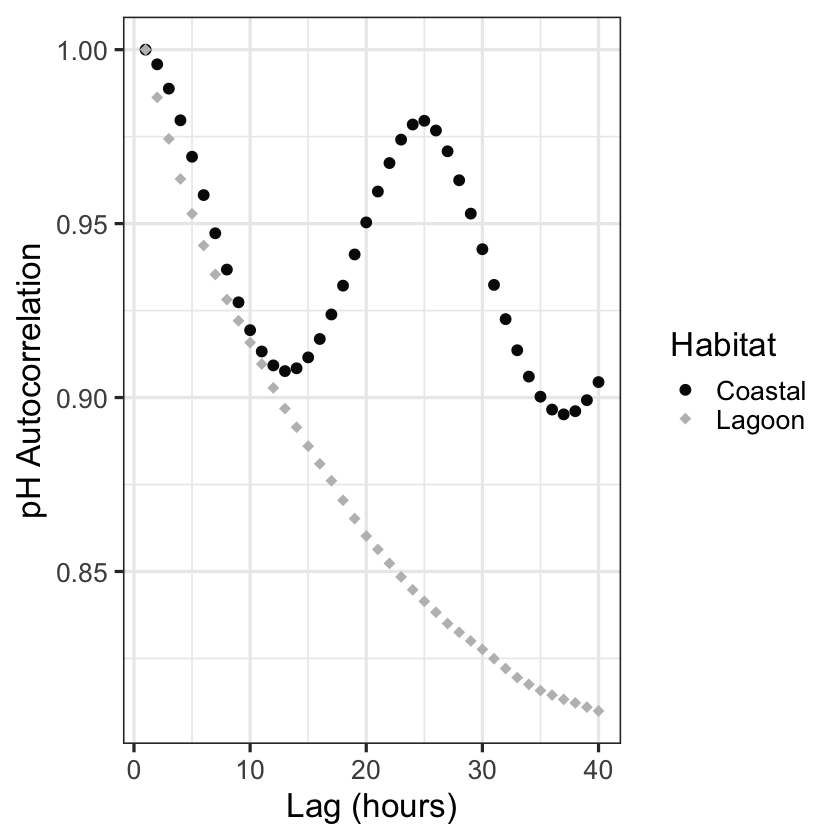

In [20]:
#Plotting autocorrelation with hourly lag
p <- ggplot(all.auto, aes(x = Lag, y = Autocorr, shape = Habitat, colour = Habitat)) +
    geom_point(size = 3)+
    scale_shape_manual("Habitat", values = c("Lagoon" = 18, "Coastal" = 16)) +
    scale_colour_manual("Habitat", values = c("Lagoon" = "grey", "Coastal" = "grey3")) +
    ylab("pH Autocorrelation") +
    xlab("Lag (hours)") +
    theme_bw(base_size = 20)
p + ggsave("./pH_hourly_autocorr_bw.pdf")

In [21]:
#Computing autocorrelation with daily lags

#take average of every day's pH
bay_daily <- as.data.frame(sapply(split(bay$pH, rep(1:(nrow(bay)/24), each=24)), mean))
colnames(bay_daily) <- c("pH")
lagoon_daily <- as.data.frame(sapply(split(lagoon$pH, rep(1:(nrow(lagoon)/24), each=24)), mean))
colnames(lagoon_daily) <- c("pH")

#re-run autocorrelation on average daily values
b.auto <- acf(bay_daily$pH, plot = FALSE)
l.auto <- acf(lagoon_daily$pH, plot = FALSE)



b.auto <- as.data.frame(b.auto$acf[0:28])
b.auto$Lag <- seq(from = 1, to = 28, by = 1)
colnames(b.auto) <- c("Autocorr", "Lag")
l.auto <- as.data.frame(l.auto$acf[0:28])
l.auto$Lag <- seq(from = 1, to = 28, by = 1)
colnames(l.auto) <- c("Autocorr", "Lag")

b.auto$Habitat <- "Coastal"
l.auto$Habitat <- "Lagoon"

all.auto <- rbind(b.auto, l.auto)


Warning message in split.default(bay$pH, rep(1:(nrow(bay)/24), each = 24)):
“data length is not a multiple of split variable”

Saving 7 x 7 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

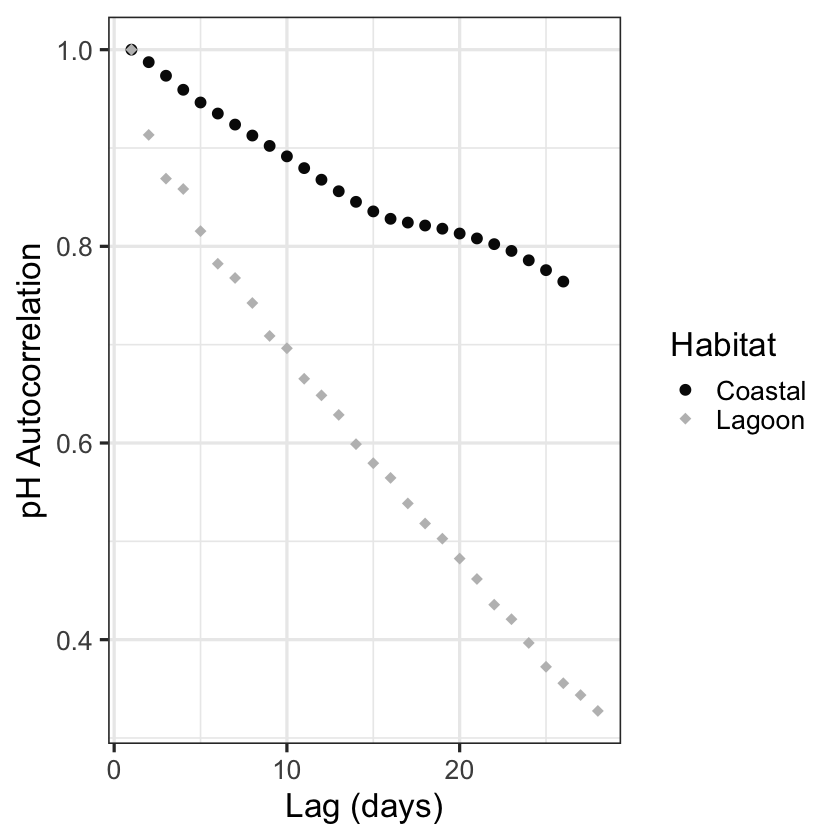

In [22]:
#daily lag plot 

p <- ggplot(all.auto, aes(x = Lag, y = Autocorr, shape = Habitat, colour = Habitat)) +
    geom_point(size = 3)+
    scale_shape_manual("Habitat", values = c("Lagoon" = 18, "Coastal" = 16)) +
    scale_colour_manual("Habitat", values = c("Lagoon" = "grey", "Coastal" = "grey3")) +
    ylab("pH Autocorrelation") +
    xlab("Lag (days)") +
    theme_bw(base_size = 20)
p + ggsave("./pH_daily_autocorr_bw.pdf")




Now exploring differences in the cue reliability at each site.

Temperature is the proxy for cue


In [23]:
#Correlation coefficients of pH and temperature at each site

cor(bay$pH, bay$Temp)
cor(lagoon$pH, lagoon$Temp)


corr_bay <- cor.test(x=bay$Temp, y=bay$pH, method = 'pearson')
corr_lag <- cor.test(x=lagoon$Temp, y=lagoon$pH, method = 'pearson')

corr_bay
corr_lag

[1] -0.8959052

[1] -0.1710229


	Pearson's product-moment correlation

data:  bay$Temp and bay$pH
t = -180.86, df = 8043, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9001350 -0.8915064
sample estimates:
       cor 
-0.8959052 



	Pearson's product-moment correlation

data:  lagoon$Temp and lagoon$pH
t = -22.625, df = 16990, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1855816 -0.1563891
sample estimates:
       cor 
-0.1710229 


Saving 7 x 7 in image
Saving 7 x 7 in image


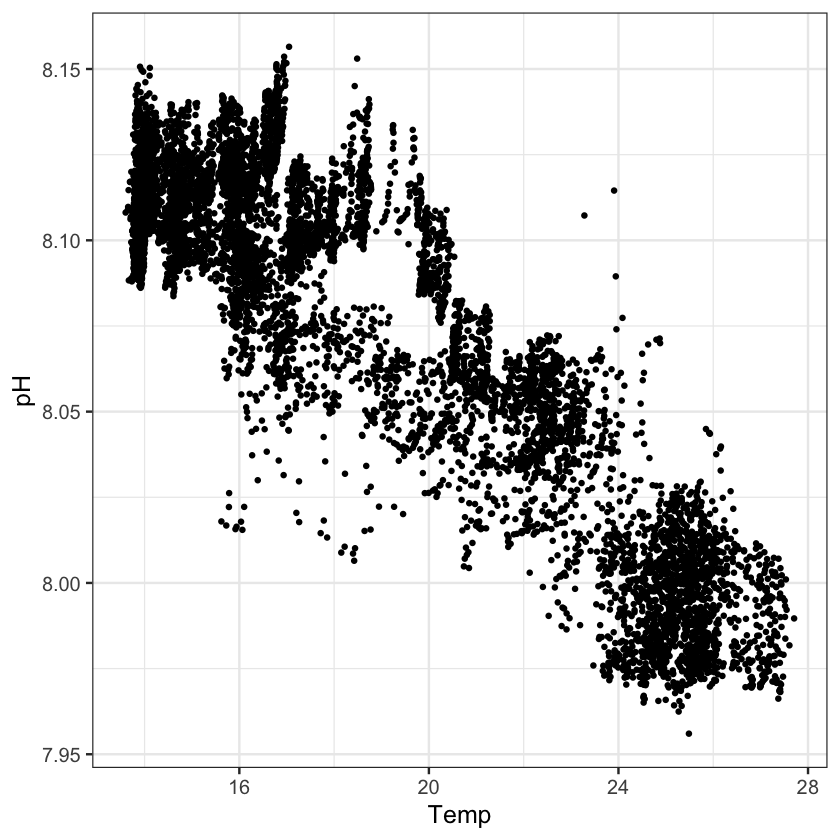

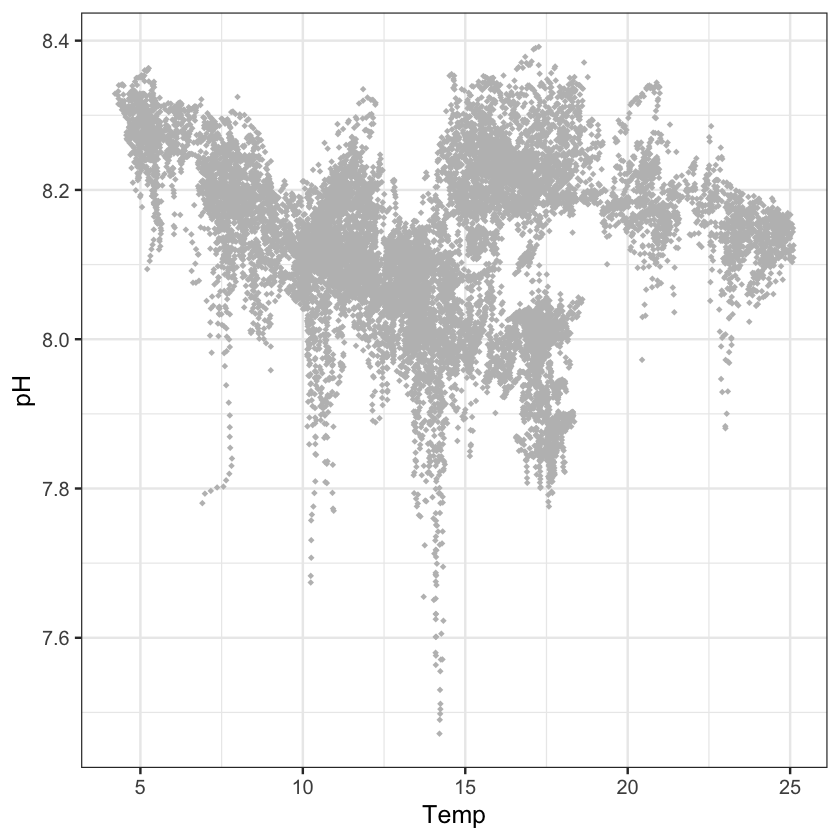

In [24]:
#Plot correlation using scatter bw

b <- ggplot(bay, aes(x = Temp, y = pH)) +
    geom_point(alpha = 1, shape = 16) +
    geom_abline(intercept = 1, slope = -1) +
    theme_bw(base_size = 15)

b + ggsave("./bay_tempcorr_bw.pdf")

l <- ggplot(lagoon, aes(x = Temp, y = pH)) +
    geom_point(alpha = 1, shape = 18, colour = "grey") +
    geom_abline(intercept = 1, slope = -1) +
    theme_bw(base_size = 15)

l + ggsave("./lagoon_tempcorr_bw.pdf")


Saving 7 x 7 in image
Saving 7 x 7 in image


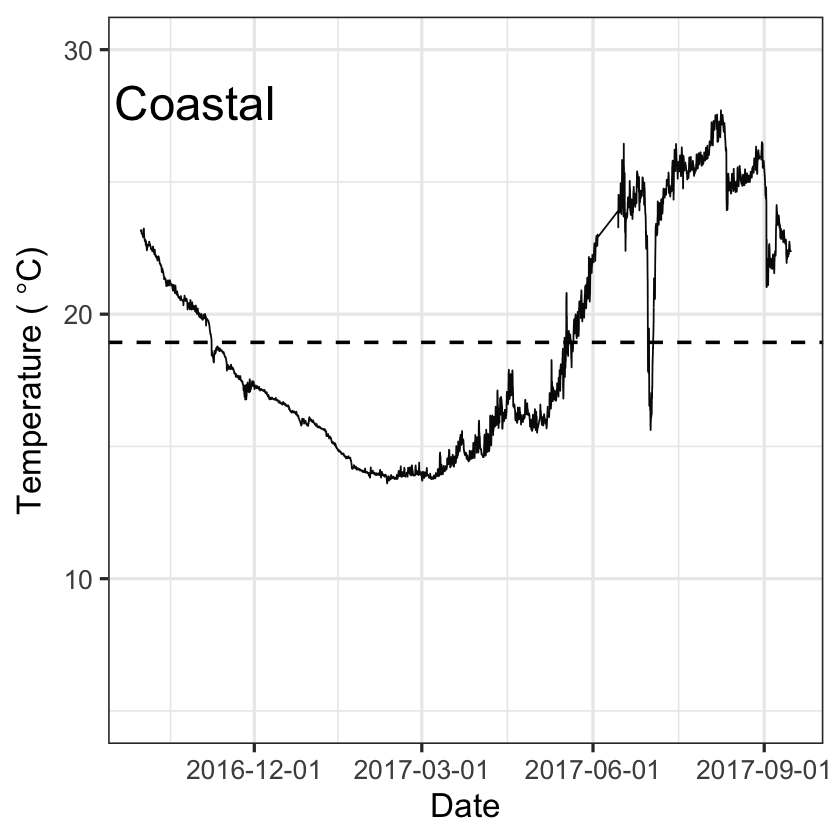

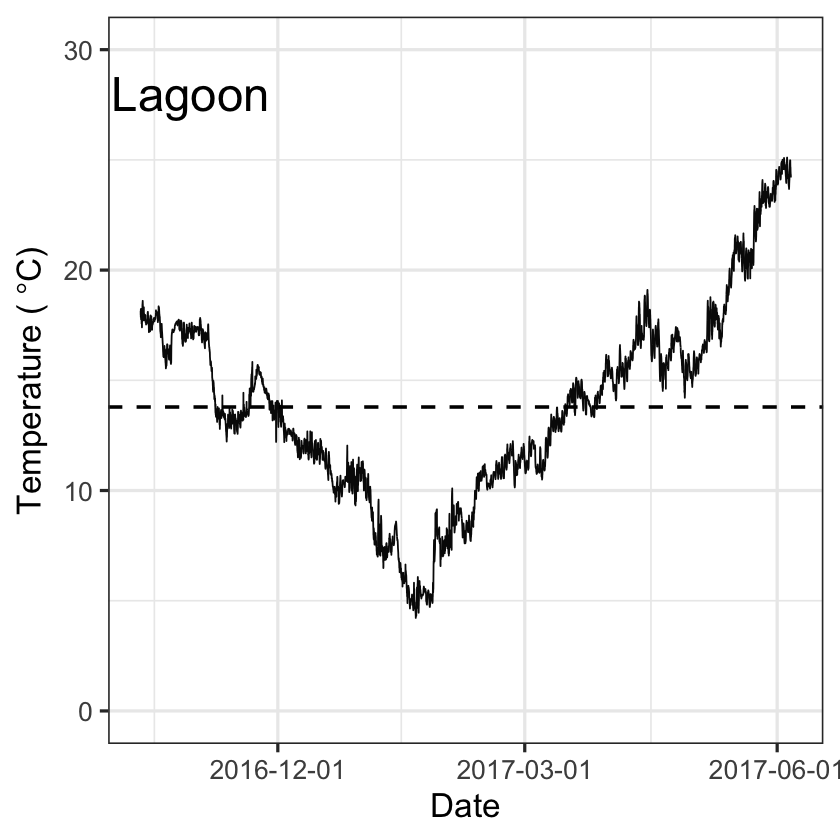

In [25]:
##Lastly, simply plotting temperature profiles at each site



bay_temp <- ggplot(data = bay, aes(Date, Temp)) +
    geom_line(colour = 'grey3') +
    ylim(5, 30) +
    geom_hline(yintercept = mean(bay$Temp) , colour = "black", linetype="dashed", size = 1) +
    xlab("Date") + 
    ylab(expression(paste('Temperature (',~degree,'C)',sep=''))) +
    theme_bw(base_size = 20) +
    scale_x_datetime(date_breaks = "3 month") +
    annotate("text", x = bay[700,1], y = 28, label = "Coastal", size = 10)


bay_temp + ggsave("./bay_temp_bw.pdf") 

lagoon_temp <- ggplot(data = lagoon, aes(Date, Temp)) +
    geom_line(colour = 'grey3') +
    ylim(0, 30) +
    geom_hline(yintercept = mean(lagoon$Temp) , colour = "black", linetype="dashed", size = 1) +
    xlab("Date") +
    ylab(expression(paste('Temperature (',~degree,'C)',sep=''))) +
    theme_bw(base_size = 20) +
    scale_x_datetime(date_breaks = "3 month") +
    annotate("text", x = bay[700,1], y = 28, label = "Lagoon", size = 10)


lagoon_temp + ggsave("./lagoon_temp_bw.pdf") 
